In [1]:
import random
import pandas as pd
import numpy as np
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
import json
from sklearn.metrics import classification_report, roc_auc_score
from scipy import interpolate
from sklearn.metrics import roc_curve, auc
from cycler import cycler
import os

import uproot ## means uproot4
import sklearn.metrics as m

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

In [2]:
CustNanoData = {
    # 'SingleMuon': "/data/bond/lyazj/Tree/V0/Merged/2018/Data/Tree_SingleMuon_*.root",
    # 'QCD': "/data/bond/lyazj/Tree/V0/Merged/2018/MC/Tree_QCD.root",
    'SingleMuon': "/home/pku/lyazj/Tree_SingleMuon_*.root",
    'QCD': "/home/pku/lyazj/Tree_QCD.root",
}
events = { }
for typefile in CustNanoData:
    events[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree"}) ## lazy means lazy computation style
    # for var in ak_arrays.fields:
    #     if "HLT" in var or "FatJet" in var:
    #         events[year][var] = ak_arrays[var]

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


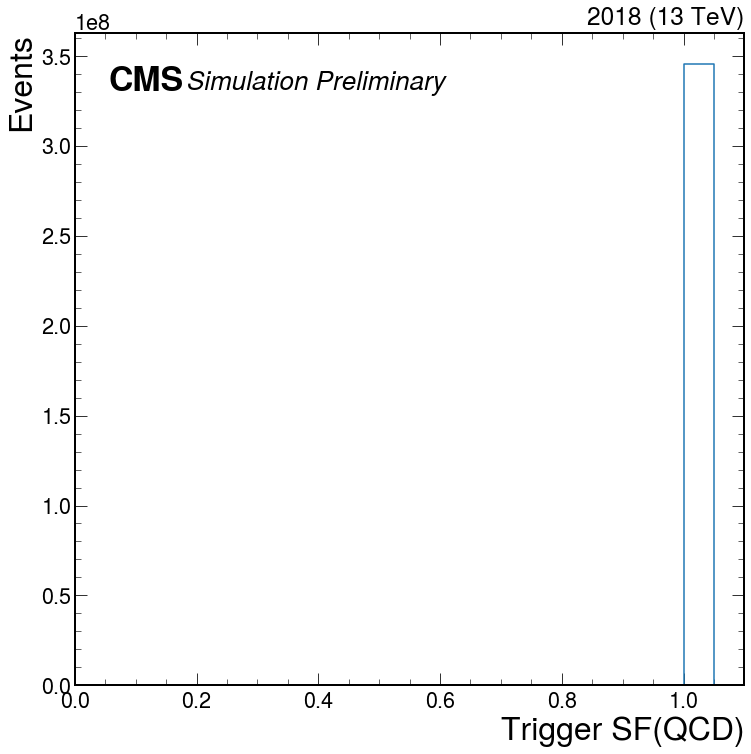

In [3]:
SFbins, SFmin, SFmax = 20, 0.05, 1.05
plt.figure(figsize=(12,12))
ax=plt.gca()
try:
    hep.cms.label(data=False, paper=False, supplementary=False, year=2018, ax=ax, fontname='sans-serif', loc=1)
except Exception:
    hep.cms.label(data=False, label='Preliminary', year=2018, ax=ax, fontname='sans-serif', loc=1)
hist1DSF = bh.Histogram(bh.axis.Regular(SFbins, SFmin, SFmax),storage=bh.storage.Weight())
eventsCut = events["QCD"][events["QCD"]["TriggerSF"] > 0.3]
hist1DSF.fill(eventsCut["TriggerSF"],weight = eventsCut["weight"])
h, err = hist1DSF.view().value, np.sqrt(hist1DSF.view().variance)
hep.histplot(h, bins=hist1DSF.axes[0].edges, yerr=err, histtype='step', stack=False)
plt.xlabel(r"Trigger SF(QCD)", fontsize=32, ha='right', x=1)
plt.ylabel(r"Events", fontsize=32, ha='right', y=1)
plt.savefig("2018QCDTriggerSF.pdf", bbox_inches='tight')
plt.show()

In [4]:
# Plot 2D trigger efficiency SFs uncertainty.
def SF2DUnc_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    try:
        hep.cms.label(data=isData, paper=False, supplementary=False, year=2018, ax=ax, fontname='sans-serif')
    except Exception:
        hep.cms.label(data=isData, label='Preliminary', year=2018, ax=ax, fontname='sans-serif')
    mmin = 30.0
    mmax = 230.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsData["HLT_PFHT1050"] == True) | (eventsData["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsData["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value


    Effi2DSF = EffiData2D/EffiMC2D

    #Start to calculate the uncentainty.
    Invera = 1./hist2DData_Cut.view().value
    Inverc = 1./hist2DData.view().value
    Inverb = 1./hist2DMC.view().value
    Inverd = 1./hist2DMC_Cut.view().value
    Sa = hist2DData_Cut.view().variance
    Sc = hist2DData.view().variance
    Sb = hist2DMC.view().variance
    Sd = hist2DMC_Cut.view().variance
                
    RelaUnc = np.sqrt( (Invera**2) * Sa + (Inverb**2) * Sb + (Inverc**2) * Sc + (Inverd**2) * Sd )
    Unc = Effi2DSF * RelaUnc

    #define mesh
    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Unc.T , vmin = 0, vmax = 1 )
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Unc
    # print(h)
    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2018_unc.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor uncertainty', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=32,color="black", x = 0.3, y = 0.9)

    plt.xlabel(r"Wcb candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Wcb candidate jet $p_{T}$", fontsize=32, ha='right', y=1)
    plt.savefig("2018Unc" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')

    plt.show()

/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: divide by zero encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: divide by zero encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in multiply


When mass =  30.0  pT =  200.0 SF =  0.014966893175229014
When mass =  30.0  pT =  220.0 SF =  0.015293792546731213
When mass =  30.0  pT =  240.0 SF =  0.017106633965027023
When mass =  30.0  pT =  260.0 SF =  0.019359040995869294
When mass =  30.0  pT =  280.0 SF =  0.021303442096058483
When mass =  30.0  pT =  300.0 SF =  0.021182943375708405
When mass =  30.0  pT =  320.0 SF =  0.017623547450395325
When mass =  30.0  pT =  340.0 SF =  0.013690821153096704
When mass =  30.0  pT =  360.0 SF =  0.009221132632913817
When mass =  30.0  pT =  380.0 SF =  0.00671861130779111
When mass =  30.0  pT =  400.0 SF =  0.006904268885749142
When mass =  30.0  pT =  420.0 SF =  0.009122784753831275
When mass =  30.0  pT =  440.0 SF =  0.012181188177818164
When mass =  30.0  pT =  460.0 SF =  0.014437297740989072
When mass =  30.0  pT =  480.0 SF =  0.016349154652187437
When mass =  30.0  pT =  500.0 SF =  0.017480412966103316
When mass =  30.0  pT =  520.0 SF =  0.019054099429619897
When mass =  30

When mass =  100.0  pT =  280.0 SF =  0.017767868891904254
When mass =  100.0  pT =  300.0 SF =  0.017589739428224428
When mass =  100.0  pT =  320.0 SF =  0.015605617589182835
When mass =  100.0  pT =  340.0 SF =  0.012510180271567226
When mass =  100.0  pT =  360.0 SF =  0.00951512159887551
When mass =  100.0  pT =  380.0 SF =  0.007025806432126931
When mass =  100.0  pT =  400.0 SF =  0.006998463355737892
When mass =  100.0  pT =  420.0 SF =  0.009558218378097364
When mass =  100.0  pT =  440.0 SF =  0.013222657680187712
When mass =  100.0  pT =  460.0 SF =  0.016643839783454815
When mass =  100.0  pT =  480.0 SF =  0.019473935698038833
When mass =  100.0  pT =  500.0 SF =  0.02191043413039451
When mass =  100.0  pT =  520.0 SF =  0.024606190988977206
When mass =  100.0  pT =  540.0 SF =  0.02734999040924065
When mass =  100.0  pT =  560.0 SF =  0.03126205577258858
When mass =  100.0  pT =  580.0 SF =  0.033748141976733995
When mass =  110.0  pT =  200.0 SF =  0.19730868083663497
Wh

When mass =  170.0  pT =  380.0 SF =  0.021344079447216214
When mass =  170.0  pT =  400.0 SF =  0.01557141851520369
When mass =  170.0  pT =  420.0 SF =  0.017067679918363377
When mass =  170.0  pT =  440.0 SF =  0.020769932440875053
When mass =  170.0  pT =  460.0 SF =  0.02321562448431527
When mass =  170.0  pT =  480.0 SF =  0.025878313578045646
When mass =  170.0  pT =  500.0 SF =  0.027747132310997034
When mass =  170.0  pT =  520.0 SF =  0.030524039250354004
When mass =  170.0  pT =  540.0 SF =  0.032788028262358423
When mass =  170.0  pT =  560.0 SF =  0.0359515768512
When mass =  170.0  pT =  580.0 SF =  0.037663555110719164
When mass =  180.0  pT =  200.0 SF =  nan
When mass =  180.0  pT =  220.0 SF =  nan
When mass =  180.0  pT =  240.0 SF =  nan
When mass =  180.0  pT =  260.0 SF =  nan
When mass =  180.0  pT =  280.0 SF =  nan
When mass =  180.0  pT =  300.0 SF =  1.1440086977811426
When mass =  180.0  pT =  320.0 SF =  0.37231314397927917
When mass =  180.0  pT =  340.0 S

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


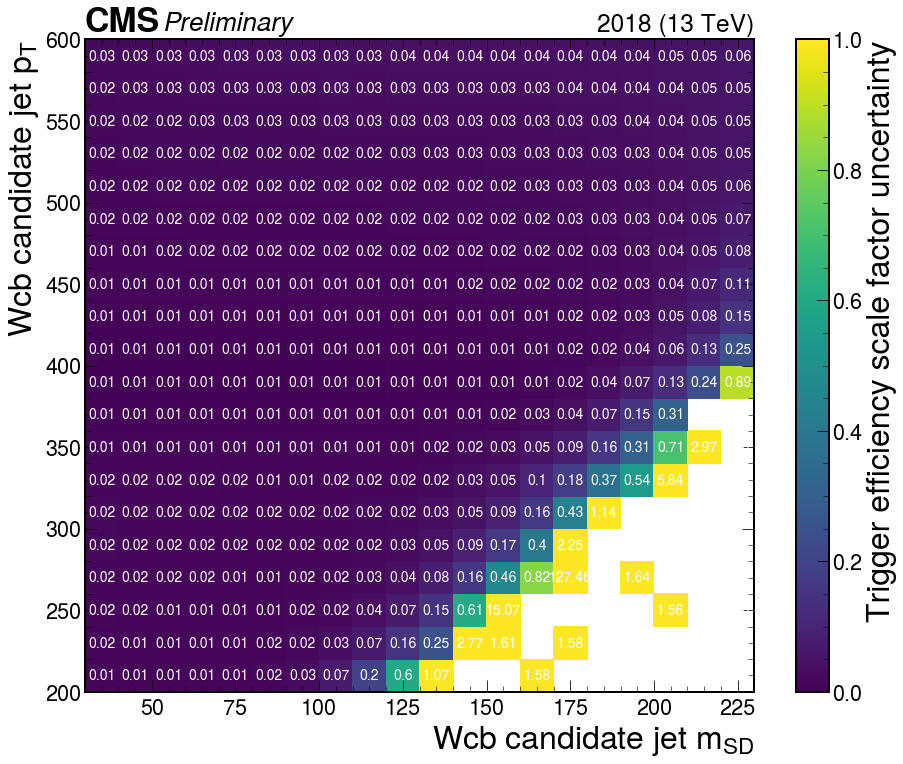

In [5]:
SF2DUnc_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"], x_label="Mja", y_label = "PTja", legend_location='lower right')

In [6]:
# Plot 2D trigger efficiency SFs, with the text inside the bins.
def plot_effi_withvalue(eventsMC,eventsData, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    try:
        hep.cms.label(data=isData, paper=False, supplementary=False, year=2018, ax=ax, fontname='sans-serif')
    except Exception:
        hep.cms.label(data=isData, label='Preliminary', year=2018, ax=ax, fontname='sans-serif')
    mmin = 30.0
    mmax = 230.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20
    
    hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])

    eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True)  | (eventsMC["HLT_AK8PFJet500"] == True) | (eventsMC["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsMC["HLT_PFHT1050"] == True) | (eventsMC["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])

    EffiMC2D = hist2DMC_Cut.view().value / hist2DMC.view().value



    hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

    eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True) | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_AK8PFJet360_TrimMass30"] == True) | (eventsData["HLT_PFHT1050"] == True) | (eventsData["HLT_AK8PFJet380_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsData["HLT_AK8PFHT750_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]
    
    hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
    hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

    EffiData2D = hist2DData_Cut.view().value / hist2DData.view().value



    Effi2DSF = EffiData2D/EffiMC2D

    # mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2DSF.T , vmin = 0, vmax = 1.5 )
    mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2DSF.T, vmin = 0.8, vmax = 1.2 )
   
    xedges = hist2DMC.axes[0].edges
    # print(xedges)
    yedges = hist2DMC.axes[1].edges
    # print(yedges)
    h = Effi2DSF
    # print(h)

    meshed_value = []
    for i in range(len(xedges)-1):
        for j in range(len(yedges)-1):
            print("When mass = ",xedges[i]," pT = ", yedges[j],"SF = ",h[i,j])
            if h[i,j] >= 0 and h[i,j] <= 5: 
                SFij = h[i,j] 
            else : SFij = 1
            dict_tmp = {
                "mass":xedges[i],
                "pT"  :yedges[j],
                "SF"  :SFij
                }
            meshed_value.append(dict_tmp)
            # print(h[i,j])
            plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
    with open('mesh_data_2018.json', 'w') as json_file:
        json.dump(meshed_value, json_file)
    
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency scale factor', rotation= 90,fontsize=32)
    # plt.title('Trigger efficiency scale factor', fontsize=3
    # 2,color="black", x = 0.35, y = 0.9)
    plt.xlabel(r"Wcb candidate jet $m_{SD}$", fontsize=32, ha='right', x=1)
    plt.ylabel(r"Wcb candidate jet $p_{T}$", fontsize=32, ha='right', y=1)
    plt.savefig("2018WithValue" + y_label + "_vs_" + x_label + "TriggerEffiSF.pdf", bbox_inches='tight')

    plt.show()

/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in true_divide
/home/pku/lyazj/.local/lib/python3.6/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide


When mass =  30.0  pT =  200.0 SF =  0.6641196399581948
When mass =  30.0  pT =  220.0 SF =  0.7585011785291343
When mass =  30.0  pT =  240.0 SF =  0.9325257845712589
When mass =  30.0  pT =  260.0 SF =  1.1080817497049193
When mass =  30.0  pT =  280.0 SF =  1.3040963121866485
When mass =  30.0  pT =  300.0 SF =  1.406911542380092
When mass =  30.0  pT =  320.0 SF =  1.1894176269700107
When mass =  30.0  pT =  340.0 SF =  0.9507149983577048
When mass =  30.0  pT =  360.0 SF =  0.6519815492050737
When mass =  30.0  pT =  380.0 SF =  0.47519628377037043
When mass =  30.0  pT =  400.0 SF =  0.48743930649741524
When mass =  30.0  pT =  420.0 SF =  0.6589358219813278
When mass =  30.0  pT =  440.0 SF =  0.862882645093728
When mass =  30.0  pT =  460.0 SF =  0.9559036315943541
When mass =  30.0  pT =  480.0 SF =  0.9858017021314115
When mass =  30.0  pT =  500.0 SF =  0.9748104422401621
When mass =  30.0  pT =  520.0 SF =  0.9647555082619016
When mass =  30.0  pT =  540.0 SF =  0.966402874

When mass =  160.0  pT =  200.0 SF =  1.0
When mass =  160.0  pT =  220.0 SF =  nan
When mass =  160.0  pT =  240.0 SF =  0.0
When mass =  160.0  pT =  260.0 SF =  0.7200293527714774
When mass =  160.0  pT =  280.0 SF =  0.8855490773059753
When mass =  160.0  pT =  300.0 SF =  1.0216176827591559
When mass =  160.0  pT =  320.0 SF =  1.2999617461617308
When mass =  160.0  pT =  340.0 SF =  0.9734990723527132
When mass =  160.0  pT =  360.0 SF =  0.7276017738634452
When mass =  160.0  pT =  380.0 SF =  0.5222335484922993
When mass =  160.0  pT =  400.0 SF =  0.5001801420295805
When mass =  160.0  pT =  420.0 SF =  0.6136030478408074
When mass =  160.0  pT =  440.0 SF =  0.8184755980408513
When mass =  160.0  pT =  460.0 SF =  0.934263998837269
When mass =  160.0  pT =  480.0 SF =  0.981145699468117
When mass =  160.0  pT =  500.0 SF =  0.9900473720151058
When mass =  160.0  pT =  520.0 SF =  0.9939993021357502
When mass =  160.0  pT =  540.0 SF =  0.9990891391049059
When mass =  160.0  p

'texgyreheros-bold.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-italic.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


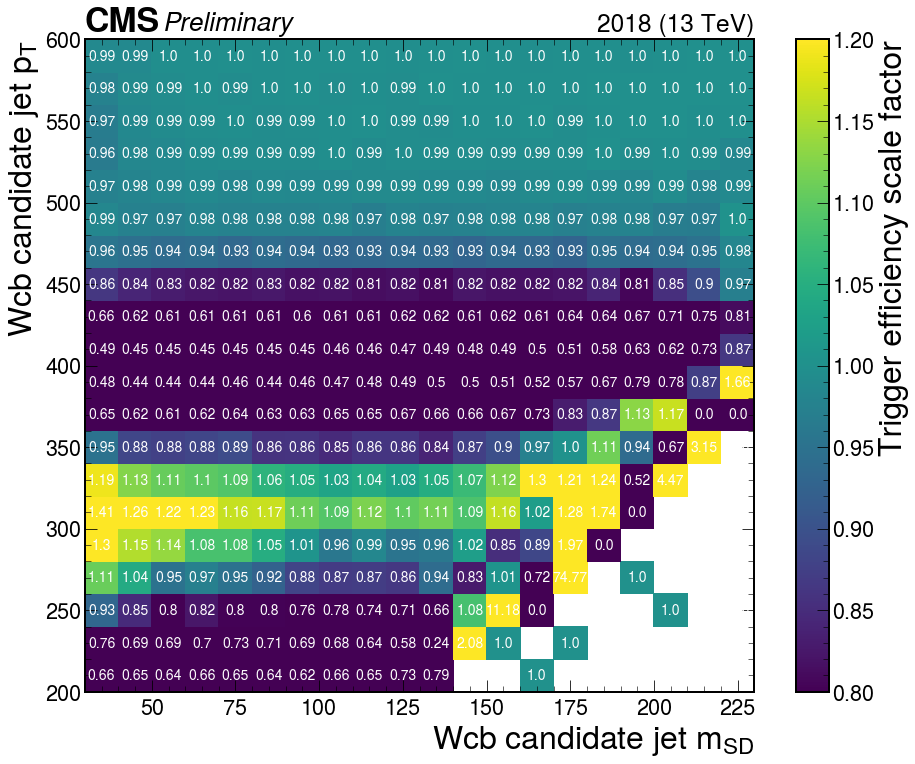

In [7]:
plot_effi_withvalue(eventsMC=events["QCD"], eventsData=events["SingleMuon"], x_label="Mja", y_label = "PTja", legend_location='lower right')

### (optional) plot the 2D trigger efficiency distributionm

In [8]:
#Plot 2D trigger efficiency SFs.
def TriggerEff2D(eventsMC, x_label, y_label, isData = True, xmin = 200, xmax = 1200, bins = 500, legend_location='best'):
    if x_label == y_label: return
    """
    events: a dictionary, events.values() are collections of events
    """
    x_score, y_score = 'score_'+x_label, 'score_'+y_label
    # ax = plt.figure(figsize=(10,10))
    plt.figure(figsize=(15,12))
    ax=plt.gca()
    # fig ,ax = plt.subplots()
    hep.cms.label(data= isData, label = "Preliminary", year="2018", ax=ax, fontname='sans-serif')
    mmin = 40.0
    mmax = 240.0
    mbins = 20

    ptmin = 200.0
    ptmax = 600.0
    ptbins = 20

    if isData:
        eventsData = eventsMC

        hist2DData = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData.fill(eventsData["Mj_V2_a"],eventsData["PTj_V2_a"])

        eventsData_Cut = eventsData[ (eventsData["HLT_PFJet500"] == True)  | (eventsData["HLT_AK8PFJet500"] == True) | (eventsData["HLT_PFHT1050"] == True)  | (eventsData["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsData["HLT_AK8PFJet420_TrimMass30"] == True)  | (eventsData["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsData["HLT_AK8PFHT900_TrimMass50"] == True)]

        hist2DData_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DData_Cut.fill(eventsData_Cut["Mj_V2_a"],eventsData_Cut["PTj_V2_a"])

        Effi2D = hist2DData_Cut.view().value / hist2DData.view().value
        mesh = ax.pcolormesh(*hist2DData.axes.edges.T, Effi2D.T )
        
        xedges = hist2DData.axes[0].edges
        print(xedges)
        yedges = hist2DData.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)

        Namesup = "SingleMuon:"
        namestr = "./2DSFPlots_Updated_07052023/2018DataEffi2D" + y_label + "_vs_" + x_label + ".pdf"

    else:
   
        hist2DMC = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC.fill(eventsMC["Mj_V2_a"],eventsMC["PTj_V2_a"],weight = eventsMC["weight"])
    
        eventsMC_Cut = eventsMC[ (eventsMC["HLT_PFJet500"] == True) | (eventsMC["HLT_AK8PFJet500"] == True)  | (eventsMC["HLT_PFHT1050"] == True)  | (eventsMC["HLT_AK8PFJet400_TrimMass30"] == True) | (eventsMC["HLT_AK8PFJet420_TrimMass30"] == True) | (eventsMC["HLT_AK8PFHT800_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT850_TrimMass50"] == True) | (eventsMC["HLT_AK8PFHT900_TrimMass50"] == True)]
        
        hist2DMC_Cut = bh.Histogram(bh.axis.Regular(mbins, mmin, mmax),bh.axis.Regular(ptbins, ptmin, ptmax),storage=bh.storage.Weight())
        hist2DMC_Cut.fill(eventsMC_Cut["Mj_V2_a"],eventsMC_Cut["PTj_V2_a"],weight = eventsMC_Cut["weight"]*eventsMC_Cut["TriggerSF"])
    
        Effi2D = hist2DMC_Cut.view().value / hist2DMC.view().value
        mesh = ax.pcolormesh(*hist2DMC.axes.edges.T, Effi2D.T )
        
        xedges = hist2DMC.axes[0].edges
        print(xedges)
        yedges = hist2DMC.axes[1].edges
        print(yedges)
        h = Effi2D
        print(h)
        
        for i in range(len(xedges)-1):
            for j in range(len(yedges)-1):
                print(h[i,j])
                plt.text(xedges[i]+0.5*(xedges[i+1]-xedges[i]), yedges[j]+0.5*(yedges[j+1]-yedges[j]), round(h[i,j],2), color='white', ha='center', va='center',fontsize = 14)
       
        Namesup = "QCD:"
        namestr = "./2DSFPlots_Updated_07052023/2018QCDEffi2D" + y_label + "_vs_" + x_label + ".pdf"





    # plt.title('2D-Trigger Efficiency', fontsize=32,color="black", x = 0.3, y = 0.9)
    cbar = plt.colorbar(mesh)
    cbar.set_label('Trigger efficiency', rotation= 90,fontsize=32)
    plt.xlabel(Namesup + r"Higgs candidate jet $m_{SD}$", fontsize=20, ha='right', x=1)
    plt.ylabel(Namesup + r"Higgs candidate jet $p_{T}$", fontsize=20, ha='right', y=1)
    plt.savefig(namestr, bbox_inches='tight')

    plt.show()

TypeError: _exp_label() got an unexpected keyword argument 'label'

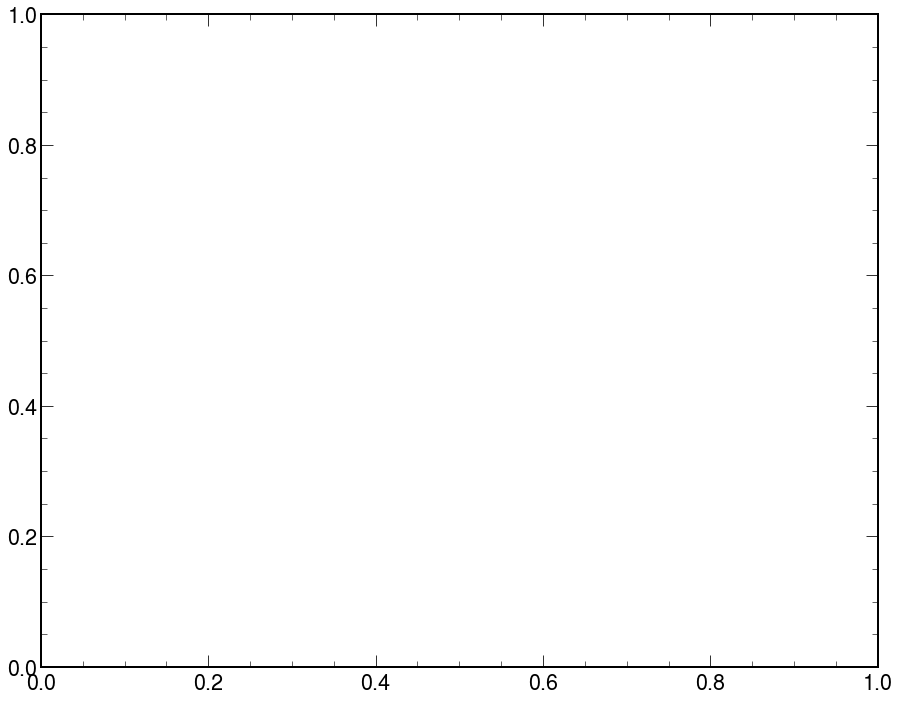

In [9]:
TriggerEff2D(eventsMC=events["SingleMuon"],isData = True,  x_label="Mja", y_label = "PTja",legend_location='lower right')


In [ ]:
TriggerEff2D(eventsMC=events["QCD"],isData = False,  x_label="Mja", y_label = "PTja",legend_location='lower right')
# TriggerEff2D(eventsMC=events["JetHT"],isData = True,  x_label="Mja", y_label = "PTja",legend_location='lower right')
